<a href="https://colab.research.google.com/github/LucasDVirtuoso/M-todos-Estat-sticos-de-Previs-o---Cesta-B-sica/blob/main/cestabasica_nepe_sjdr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MÉTODOS ESTATÍSTICOS DE PREVISÃO - PREVISÃO DO VALOR DA CESTA BÁSICA DE SÃO JOÃO DEL REI**


**O objetivo é a partir de dados coletados do Núcleo de ensino pesquisa e extensão em economia (NEPE) da Universidade Federal de São João del Rei (UFSJ), analisar o custo da cesta básica na cidade de Janeiro de 1995 até Julho de 2024 e obter, por meio de séries temporais, um modelo estatístico capaz de representar o comportamento da série e prever valores futuros da cesta na cidade.**

**Algumas informações importantes:**
- A metodologia do NEPE segue a mesma metodologia do DIEESE (responsável pela coleta e divulgação dos dados da cesta básica nacional). Portanto, os itens na cesta são identicos assim como o período de coleta e tratamento dos dados, permitindo inclusive a comparação direta entre a cesta da cidade de São João e as capitais (divulgadas pelo DIEESE).

  Para mais informações: https://nepeufsj.wixsite.com/meusite

- O custo da cesta básica está expresso em reais, devido ao impacto da inflação os valores da cesta serão deflacionados com um índice baseado no IPCA. Isso permitirá compararmos os valores no tempo em relação a primeira observação (Janeiro de 1995). Também permitirá comparar de forma direta os valores com estatísticas descritivas. *Ou seja, usaremos os valores reais, não nominais, da cesta*

**Links para a documentação das principais bibliotecas utilizadas:**
- **Scikit-Learn:** https://scikit-learn.org/stable/
- **SciPy:** https://docs.scipy.org/doc/scipy/
- **Statsmodels.tsa:** https://www.statsmodels.org/stable/tsa.html
- **pmdarima:** https://alkaline-ml.com/pmdarima/modules/classes.html
- **Matplotlib:** https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
- **Pandas:** https://pandas.pydata.org/docs/index.html
- **NumPy:** https://numpy.org/
- **datetime:** https://docs.python.org/3/library/datetime.html


# INÍCIO: IMPORTAÇÃO DAS BIBLIOTECAS E DOS DADOS

In [ ]:
pip install pmdarima

In [ ]:
# Manipulação dos dados
import pandas as pd
import numpy as np

# Visualização e gráficos
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6 #define tamanho padrao das figuras

import seaborn as sns

# Google
from google.colab import drive
drive.mount('/content/drive')

# Análise de séries temporais
from datetime import datetime # manipulação das datas

from pmdarima.arima import auto_arima # ajuste automático dos parâmetros (p, q, d)
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, plot_acf, plot_pacf # visualizações
from pmdarima.arima import ADFTest # teste de raíz unitária

from statsmodels.tsa.arima.model import ARIMA # modelo ARIMA
from statsmodels.tsa.arima.model import sarimax # modelo SARIMA
from statsmodels.tsa.stattools import adfuller # teste de raíz unitária
from statsmodels.stats.diagnostic import het_arch # teste de heterocedasticidade ARCH
from statsmodels.stats.diagnostic import acorr_ljungbox #teste para autocorrelação dos resíduos (ruído branco)
from statsmodels.tsa.seasonal import seasonal_decompose # decomposição da série

from sklearn.metrics import mean_absolute_percentage_error, r2_score # métricas de avaliação
from sklearn.model_selection import train_test_split # separação dos dados em treino e teste

import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import jarque_bera

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/PROJETOS DS/MÉTODOS ESTATÍSTICOS DE PREVISÃO_Custo da cesta básica em São João del-Rei/Dados/Brutos/base_cestabasica_sjdr.xlsx'
df = pd.read_excel(path, sheet_name='principal')

Os dados importados precisam ser tratados inicialmente.

# **Limpeza e tratamento dos dados**

In [ ]:
df.shape

(355, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   mes                             355 non-null    datetime64[ns]
 1   custo                           323 non-null    float64       
 2   ipca_numero_indice_(dez94=100)  355 non-null    float64       
 3   deflacionado                    323 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.2 KB


In [ ]:
df.head()

,mes,custo,ipca_numero_indice_(dez94=100),deflacionado
0,1995-01-01,61.11,1033.74,5.911544
1,1995-02-01,62.33,1044.28,5.968706
2,1995-03-01,63.55,1060.47,5.992626
3,1995-04-01,64.06,1086.24,5.897408
4,1995-05-01,63.37,1115.24,5.682185


In [ ]:
df.isnull().sum()

,0
mes,0
custo,32
ipca_numero_indice_(dez94=100),0
deflacionado,32


---

Inicialmente observa-se os dados de forma mais geral para verificar problemas, em resumo temos:

- Os tipos de dados de cada coluna está correto.
- **Temos um total de 355 observações mensais**
- Devemos posteriormente definir o índice da série como seu componente de tempo (mas isso será feito mais a frente, apenas uma nota)
- **Existem valores nulos que devem ser tratados**

---

In [ ]:
# Implementa coluna com variação mensal da inflação
df['var_mes'] = df['ipca_numero_indice_(dez94=100)'].pct_change()

# Preenche o valor NaN com a variação da base de dados do ipca
df['var_mes'] = df['var_mes'].fillna(0.017)

In [ ]:
df.isnull().sum()

,0
mes,0
custo,32
ipca_numero_indice_(dez94=100),0
deflacionado,32
var_mes,0


---

- O índice de inflação (IPCA), que está em uma das colunas. Tal informação foi colocada ali pelo google spred sheets e foi extraída do site do IBGE.

- A variação percentual do índice do IPCA foi feita para tirar a variação da inflação ao mês em porcentagem, tal informação será usada para deflacionar a série.

- O valor faltante dos dados foi preenchido com base nas informações do índice do IBGE.

---

In [ ]:
# Período da série temporal, definição desse período como índice
rts = pd.date_range('1995-01-31', '2024-07-31', freq='M')
df.set_index(rts, inplace=True)
df.drop('mes', axis=1, inplace=True) #índice definido

*Existem outras formas de definir esse índice, mas deixei assim por ser diferente de set_index(...) ... "variar um pouco" apenas um lapso*

In [ ]:
#Faz a interpolação dos dados da série para preencher os dados faltantes
df['custo'] = df['custo'].interpolate(method='linear')

#Remove a coluna desnecessária
df.drop('deflacionado', axis=1, inplace=True)

In [ ]:
df.isnull().sum()

,0
custo,0
ipca_numero_indice_(dez94=100),0
var_mes,0


---

- Interpolação linear é como "advinhar" valores que estão faltando colocando uma linha reta entre os dois pontos conhecidos da série. A partir dessa linha é estimado o valor faltando, aquele que deveria estar no meio dos dois pontos conhecidos.

- Com isso os dados faltantes foram preenchidos e a série está aparentemente pronta para ser deflacionada.

---

In [ ]:
df.head(10)

,custo,ipca_numero_indice_(dez94=100),var_mes
1995-01-31,61.11,1033.74,0.017000
1995-02-28,62.33,1044.28,0.010196
1995-03-31,63.55,1060.47,0.015504
1995-04-30,64.06,1086.24,0.024301
1995-05-31,63.37,1115.24,0.026698
1995-06-30,66.31,1140.44,0.022596
1995-07-31,57.94,1167.35,0.023596
1995-08-31,60.59,1178.91,0.009903
1995-09-30,53.91,1190.58,0.009899
1995-10-31,52.06,1207.37,0.014102


---

- Resolvi exportar esses dados para o Excel para realizar a deflação lá (Acho mais prático). Depois irei importar novamente os dados para uma nova variável e continuar a análise.

- A deflação será feita da seguinte forma:

  - Janeiro de 1995 (a primeira observação) foi definido como valor 1 em uma nova coluna chamada **Fator de Deflação**

  - $\text{Fator} = 1 + \frac{\text{IPCA (%)} }{100}$  
  
   Esse fator acumula a inflação a medida que a mesma varia.

  - Com isso temos duas colunas: Os valores originais e o fator acumulado da inflação. Com isso ... Bata dividir os preços por mês pelo fator acumulado daquele mês.


**As planilhas estão disponíveis junto aos demais arquivos junto deste código**



---

In [ ]:
#df.to_excel('base_cestabasica_sjdr_final.xlsx') # exporta os dados para finalizar tratamento

---

# **Análise descritiva**

In [ ]:
path = '/content/drive/MyDrive/PROJETOS DS/MÉTODOS ESTATÍSTICOS DE PREVISÃO_Custo da cesta básica em São João del-Rei/Dados/Limpos/cestabasica_df.xlsx'
cb = pd.read_excel(path, sheet_name='base', index_col='tempo')

In [ ]:
cb.head() #visualiza os dados

,custo,ipca_numero_indice_(dez94=100),var_mes,ipca_acumulado,valor_deflacionado,Varição real da cesta no período
tempo,,,,,,
1995-01-01,61.11,1033.74,0.017000,1.000000,61.110000,0.000000
1995-02-01,62.33,1044.28,0.010196,1.010196,61.700898,0.009669
1995-03-01,63.55,1060.47,0.015504,1.025858,61.948171,0.004008
1995-04-01,64.06,1086.24,0.024301,1.050786,60.963861,-0.015889
1995-05-01,63.37,1115.24,0.026698,1.078840,58.739019,-0.036494


In [ ]:
# Seleciona apenas a variável que interessa
cb = cb['valor_deflacionado']
cb.head()

,valor_deflacionado
tempo,
1995-01-01,61.110000
1995-02-01,61.700898
1995-03-01,61.948171
1995-04-01,60.963861
1995-05-01,58.739019


---

- Como os dados já estão completamente tratados, devemos deixar apenas os valores deflacionados da cesta.

- Assim os dados agora estão prontos em termos de tratamento e limpeza.

---

---

- Inicialmente devemos plotar o gráfico da série e realizar uma análise visual.

- Depois devemos observar seus componentes como tendência, ciclo, sazonalidade e a parte aleatória ... Para isso, o gráfico de **decomposição da série** é bastante útil.

- Por fim uma análise descritiva de seus dados para podemos retirar os primeiros *insights*

<Axes: xlabel='tempo'>

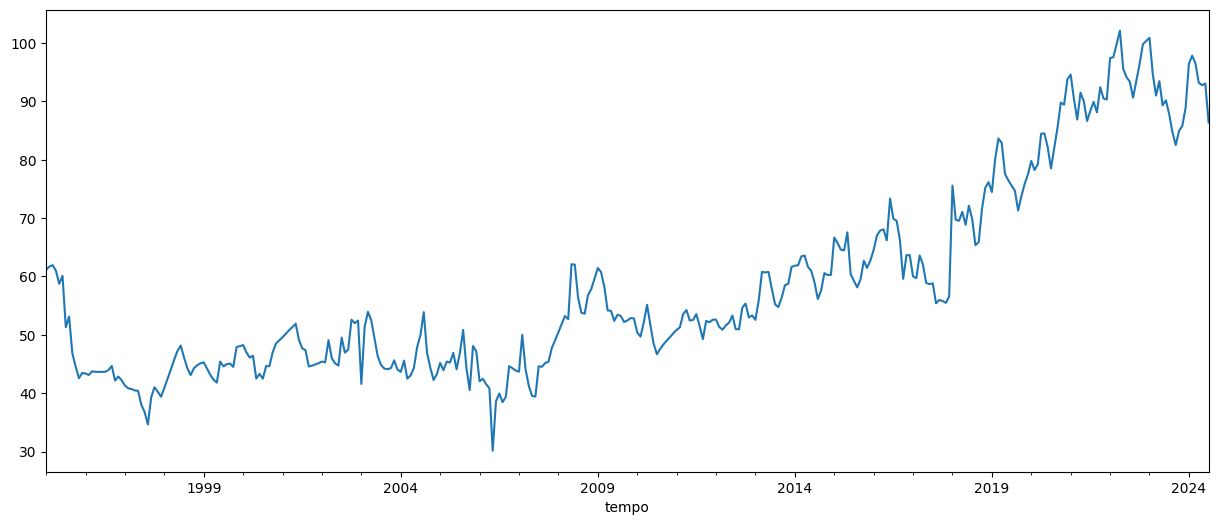

In [ ]:
cb.plot() #visualiza o gráfico da série

- Parece haver uma tendência suave a crescimento

- A sazonalidade aparenta ser suave também.


In [ ]:
# Plot série decomposta em seus componentes
serie_decomposta = seasonal_decompose(cb, model='multiplicative', period=12)

- Aqui iremos decompor a série em seus principais componentes: Tendência, Sazonalidade e parte aleatória.

- A série que estamos lidadando é considerada como um modelo de série temporal multiplicativo isso é especificado a função de decomposição no argumento *model='multiplicative'* e o argumento *period=12* define os períodos mensais dentro de um ano.

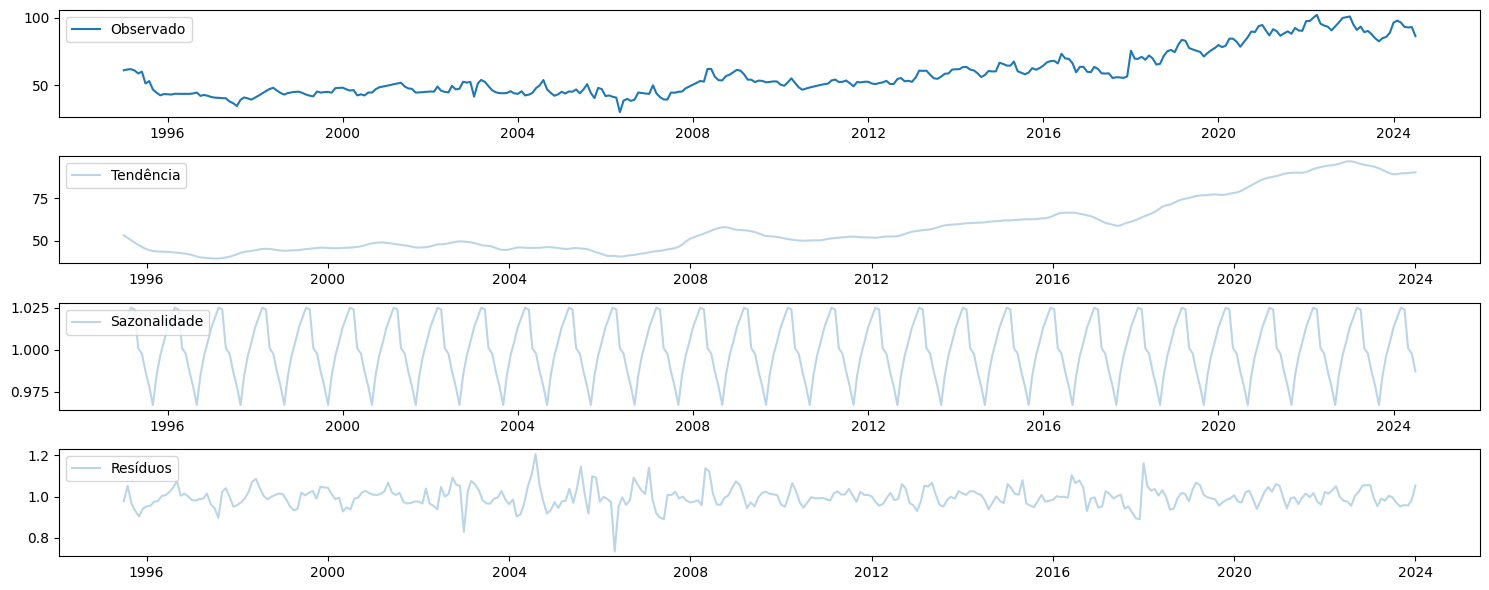

In [ ]:
# plt.suplot(abc)
# a,b,c = nº linhas do subplot, nº de colunas do subplot, índice do subplot específico

# Série observada padrão
plt.subplot(411)
plt.plot(serie_decomposta.observed, label='Observado')
plt.legend(loc='upper left')

# Tendência da série
plt.subplot(412)
plt.plot(serie_decomposta.trend, label='Tendência', alpha=.3)
plt.legend(loc='upper left')

# Sazonalidade da série
plt.subplot(413)
plt.plot(serie_decomposta.seasonal, label='Sazonalidade', alpha=.3)
plt.legend(loc='upper left')

# Ruído ou parte aleatória da série
plt.subplot(414)
plt.plot(serie_decomposta.resid, label='Resíduos', alpha=.3)
plt.legend(loc='upper left')

# Ajusta e plota o layout :p
plt.tight_layout()
plt.show()

- A série observada (original): apresenta uma aparente estabilidade até mais ou menos 2010 quanto começa a apresentar uma tendência de alta mais consistente.

- **Tendência:** Até os anos 2000 apresenta uma queda no custo, entretanto, a partir desse momento temos um aumento sustentado até mais ou menos 2022.

  **A tendência crescente sugere que fatores como inflação e mudanças econômicas podem ter elevado o custo da cesta básica no decorrer dos anos**

- **Sazonalidade:** É possível observar padrões previsíveis (que se repetem) em certos períodos de tempo dentro de um ano. Picos e vales (altas e baixos) no decorrer de cada ano, isso mostra o comportamento sazonal da série devido a fatores como colheita, clima, fatores de mercado possivelmente e etc ...

  **A sazonalidade regular confirma que eventos sazonais afetam o custo, como períodos de safra ou maior consumo em meses específicos.**

- **Resíduos:** É o que sobra ao remover os demais componentes da série.

  **Os resíduos permanecem relativamente baixos e próximos de zero ao longo da série. Isso é um indicativo de que a maior parte das variações na série é explicada pela sazonalidade e pela tendência.**

*A analise puramente visual pode induzir a muito erros então irei proseguir*

In [ ]:
cb.describe() #descrição da série

,valor_deflacionado
count,355.000000
mean,58.338160
std,16.676756
min,30.140949
25%,45.130900
50%,52.590076
75%,65.556398
max,102.115933


- Temos 355 observações na série, um valor bom para trabalhar.

- A variação dos preços cobre uma amplidute de 71,97 aproximadamente. Sendo o menor valor da série 30,14 e o maior 102,11 (considerando preços a termos de janeiro de 1995 como base). Espero que a flutuação do preço nesse amplo período seja significativa devido ao intervalo amplo da série.

- A **média** da série é de 58,39 sua **mediana** apresenta pouca variação em relação a esse valor sendo de 52,59. Como a média é um indicador mais sensível a valores descrepantes que a mediana e essas não estão muito discrepantes, isso leva a crer que existem poucos valores extremos influênciando a série a tendência central da série.

- Os quartis nos mostram que a maior parte dos custos está concentrada em valores próximos à mediana, mas há uma longa cauda para valores mais altos (102,11 - máximo).

- A dispersão dos valores em relação a média (Desvio-Padrão), foi de 16,88. Uma dispersão alta, que leva a variação significativa no custo ao longo do tempo.

**-** **Devido a dispersão alta, a série apresenta volatilitade considerável no tempo, devido a isso, espera-se que a série não seja estacionaria. Isso deve ser confirmado com testes de hipóteses.**

**-** **Podemos observar que o custo médio da cesta se manteve entorno R$58,34 considerando a mediana e os quartis podemos ver que a maioria dos valores estão concentrados próximos da mediana, que por sua vez, não diverge muito da média.**

---

# **Estacionariedade da série**

---
- Gráfico de amplitude pela média
- Estacionariedade da série

**AMPLITUDE PELA MÉDIA**

**O objetivo do gráfico é verificar a estabilidade da variância em uma série temporal. Identificar se há relação entre a média e a amplitude, o que pode indicar não estacionariedade na variância e a necessidade de trasformar a série no logaritmo de seus valores.**

*Imagine que você está observando o comportamento de um cachorro que está pulando em um gramado. Às vezes ele pula bem alto, outras vezes ele dá pulos menores. Agora, você quer saber se o cachorro está pulando de forma mais ou menos constante ao longo do tempo ou se ele está mudando muito o tamanho dos pulos. Para fazer isso, você divide o gramado em partes menores (como quadrados de 12 passos) e observa o tamanho médio dos pulos do cachorro em cada quadrado. Depois, você mede a diferença entre o maior e o menor pulo dentro de cada quadrado.*

*Quando você coloca esses dados em um gráfico, com as médias dos pulos no eixo horizontal e as diferenças no eixo vertical, consegue ver se há uma relação entre os dois. Se o gráfico mostra pontos bem espalhados, isso pode indicar que o cachorro está pulando de forma inconsistente. Se os pontos seguem um padrão claro, é como se ele tivesse uma "preferência" por pular de uma certa maneira dependendo do lugar. Isso é uma forma de ver se as mudanças são consistentes ou se têm algo estranho acontecendo, como "desníveis" no gramado.*

**A analogia acima exemplifica o quê iremos fazer a seguir para obter o gráfico, logo depois devemos realizar um teste para a inclinação da reta.**

**O teste de hipótese da inclinação da reta no gráfico de amplitude pela média é verificar se há uma relação linear significativa entre a média e a amplitude da série temporal**

*Se a medida que avança no gramado o cachorro pula cada vez mais atráves de uma relação linear*

**O objetivo é analisar a estabilidade da variância, indicando se ela depende da média (não-estacionariedade).**



In [ ]:
# Define o total de grupos e o range total da série
n_grupos = 12
n_total = len(cb)

In [ ]:
# Cria os grupos
grupos = [cb[i:i+n_grupos] for i in range(0, n_total, n_grupos)]

In [ ]:
# Calcula a amplitude e a média para os grupos
medias = [np.mean(grupo) for grupo in grupos]
amplitude = [np.max(grupo) - np.min(grupo) for grupo in grupos]

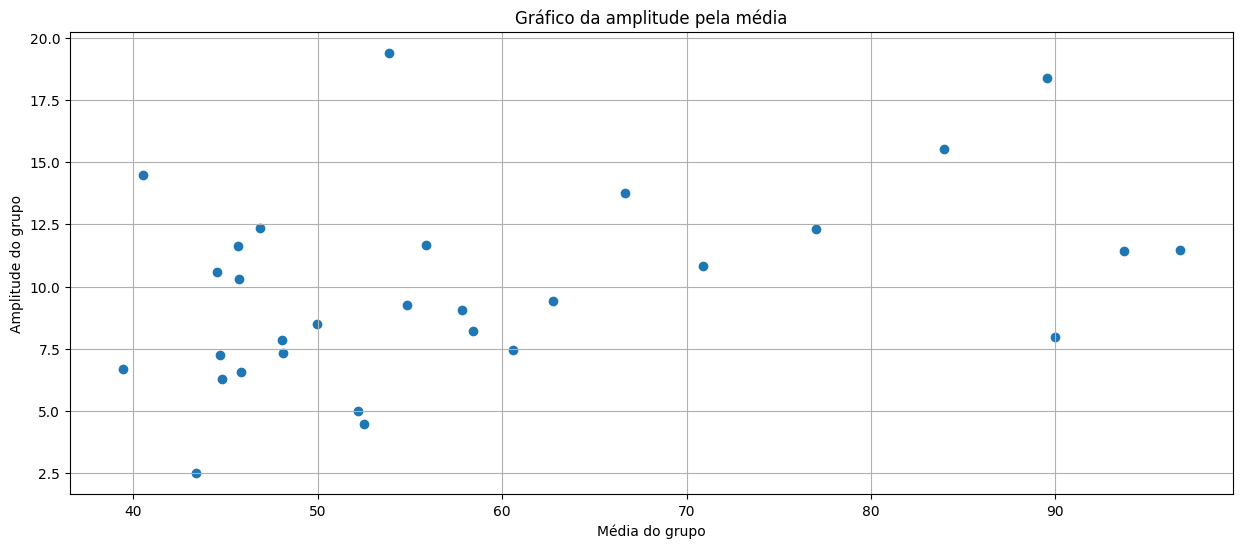

In [ ]:
# Plota o gráfico da amplitude pela média
plt.scatter(medias, amplitude)
plt.xlabel("Média do grupo")
plt.ylabel("Amplitude do grupo")
plt.title("Gráfico da amplitude pela média")
plt.grid(True)
plt.show()

In [ ]:
# Realiza o teste para a inclinação da reta
# Nível de significância = 0.05
slope, intercept, r_value, p_value, std_err = stats.linregress(medias, amplitude) # variáveis retornaveis, regressão da amplitude pela média

print(f"Inclinação: {slope}")
print(f"Intercepto: {intercept}")
print(f"p-valor: {p_value}")
print(f"Erro padrão da inclinação: {std_err}")

Inclinação: 0.09183001061483854
Intercepto: 4.526199302389479
p-valor: 0.02603438072129685
Erro padrão da inclinação: 0.03907130746332469


- Através do teste podemos rejeitar a hipótese nula de que não há relação significativa entre a média e a amplitude. **(Hipótese nula = A inclinação da reta é igual a zero)**

- Com isso podemos dizer que existe uma relação linear, entre a amplitude da série e a média dos grupos de valores dessa série. A transformação logaritmica pode ajudar a corrigir esse problema.

In [ ]:
cb_log = np.log(cb) #transformação logaritmica

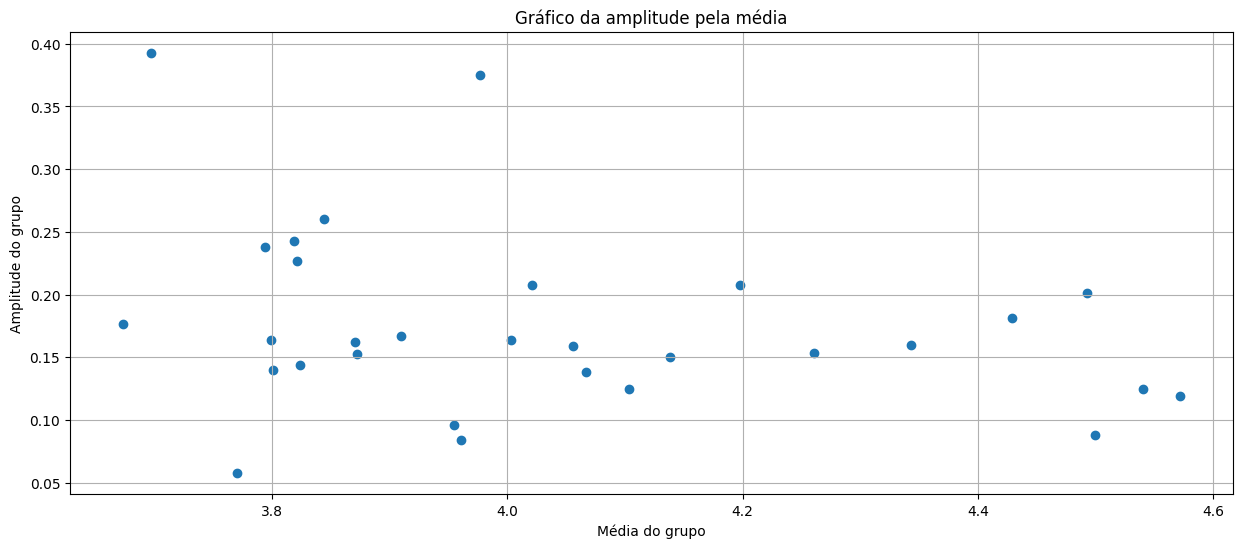

In [ ]:
# Cria os grupos
grupos = [cb_log[i:i+n_grupos] for i in range(0, n_total, n_grupos)]

# Calcula a amplitude e a média para os grupos
medias = [np.mean(grupo) for grupo in grupos]
amplitude = [np.max(grupo) - np.min(grupo) for grupo in grupos]

# Plota o gráfico da amplitude pela média
plt.scatter(medias, amplitude)
plt.xlabel("Média do grupo")
plt.ylabel("Amplitude do grupo")
plt.title("Gráfico da amplitude pela média")
plt.grid(True)
plt.show()


In [ ]:
# Realiza o teste para a inclinação da reta
# Nível de significância = 0.05
slope, intercept, r_value, p_value, std_err = stats.linregress(medias, amplitude) # variáveis retornaveis, regressão da amplitude pela média

print(f"Inclinação: {slope}")
print(f"Intercepto: {intercept}")
print(f"p-valor: {p_value}")
print(f"Erro padrão da inclinação: {std_err}")

Inclinação: -0.08161259784340949
Intercepto: 0.5045987190516702
p-valor: 0.11538323514620272
Erro padrão da inclinação: 0.050225394397933644


- Refazendo a análise podemos observar que a transformação logaritmica foi capaz de estabilizar a série. O p-valor foi superior ao intervalo de confiança e a hipótese nula de inclinação igual a zero foi satisfeita.

---

**Teste Dickey-Fuller Aumentado (ADF), é utilizado para verificar se a série temporal é estacionária (se suas propriedades são constantes ao longo do tempo). Ele testa a presença de raíz unitária na série.**

*Raíz unitária indica que os valores da série são altamente dependentes dos valores anteriores, resultando em uma tendência não-estacionária com variância crescente ao longo do tempo.*

**Resumindo iremos testar se os valores passados afetam os futuros influenciando a tendência da série e suas propriedades**

*Obs.: Usar a série logaritimizada*

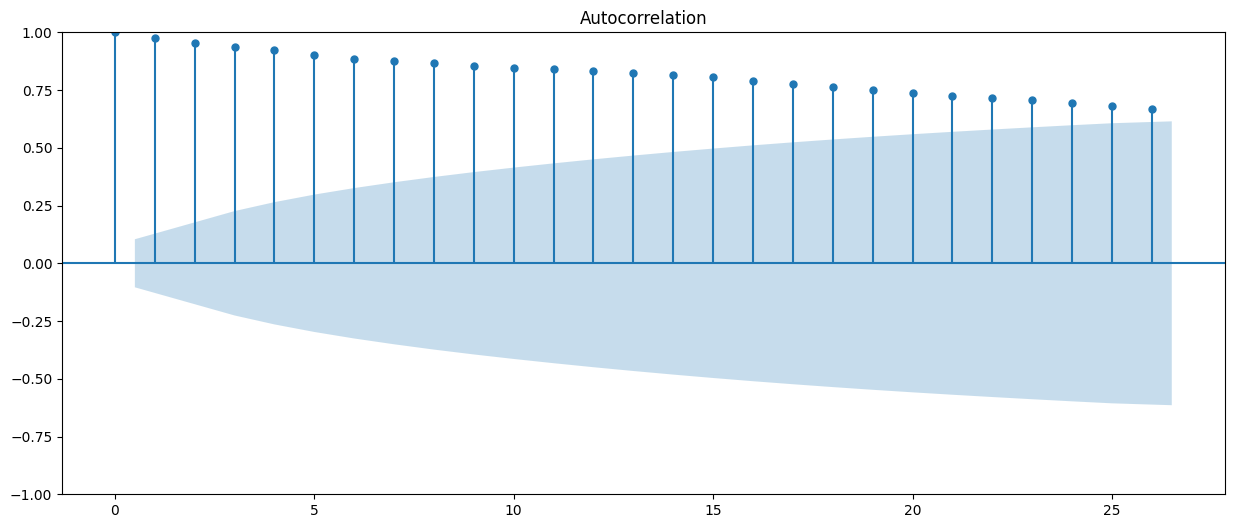

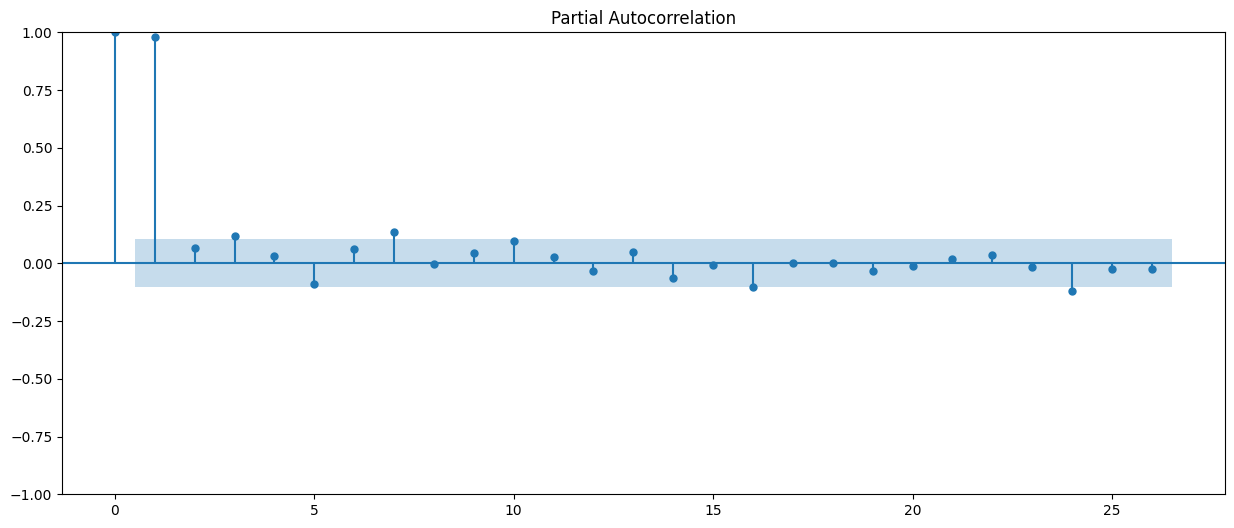

In [ ]:
# Plota as funções de autocorrelação e autocorrelação parcial para a série
plot_acf(cb_log, alpha=0.05)
plot_pacf(cb_log, alpha=0.05)

- No gráfico de ACF (1º) cada barra mostra o quanto a série está relacionada com ela mesma em diferentes defasagens. Barras altas indicam forte relação.

- No gráfico de PACF (2ª) as barras mais altas são diretamente importantes para a série, quanto mais perto de zero (barras menores) menos importantes são as defazagens.

- Pelo padrão a série não aparenta ser estacionária, com os lags fora do intervalo de confiança.

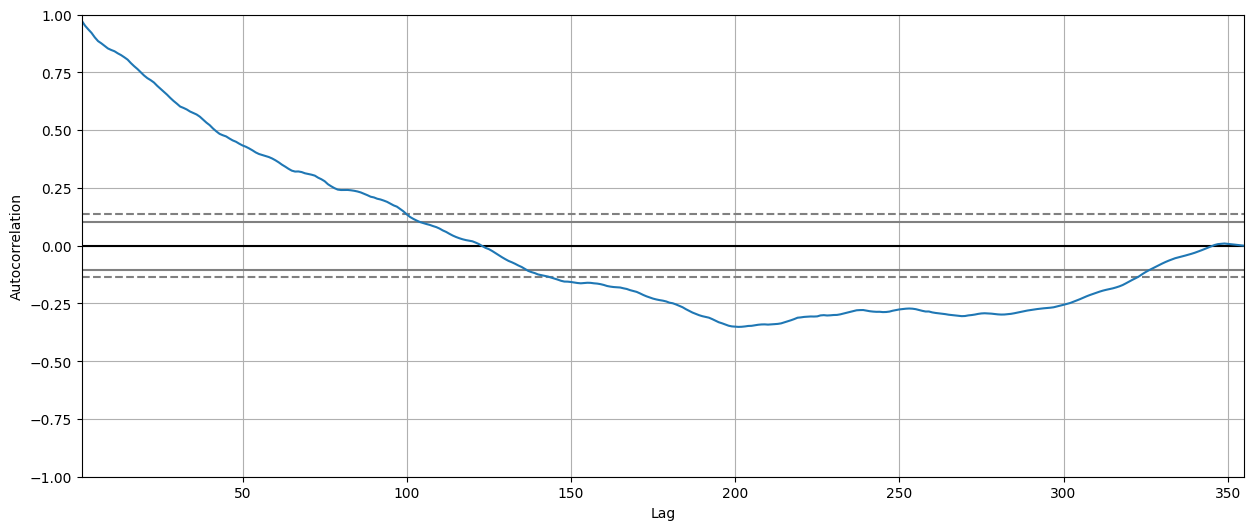

In [ ]:
autocorr_plot(cb_log) #plota autocorrelação para todos os períodos da série

In [ ]:
# Tesde Dickey-Fuller Aumentado
adf = ADFTest(alpha=0.05) #nível de significânica de 5%
valor_p, diferenca = adf.should_diff(cb_log)
print(f"Valor p: {valor_p}")
print(f"Diferença: {int(diferenca)}")

Valor p: 0.01831380994239351
Diferença: 0


In [ ]:
adf = ADFTest(alpha=0.05)
valor_p, diferenca = adf.should_diff(cb)
print(f"Valor p: {valor_p}")
print(f"Diferença: {int(diferenca)}")

Valor p: 0.15868139528953223
Diferença: 1


- A série original não rejeitou a hipótese nula do teste ADF, apresentando raíz unitária logo, não estatcionária. Há necessidade de diferenciação!

- A série logaritimizada está por sua vez estável! Sem presença de raíz unitária.

<Axes: xlabel='tempo'>

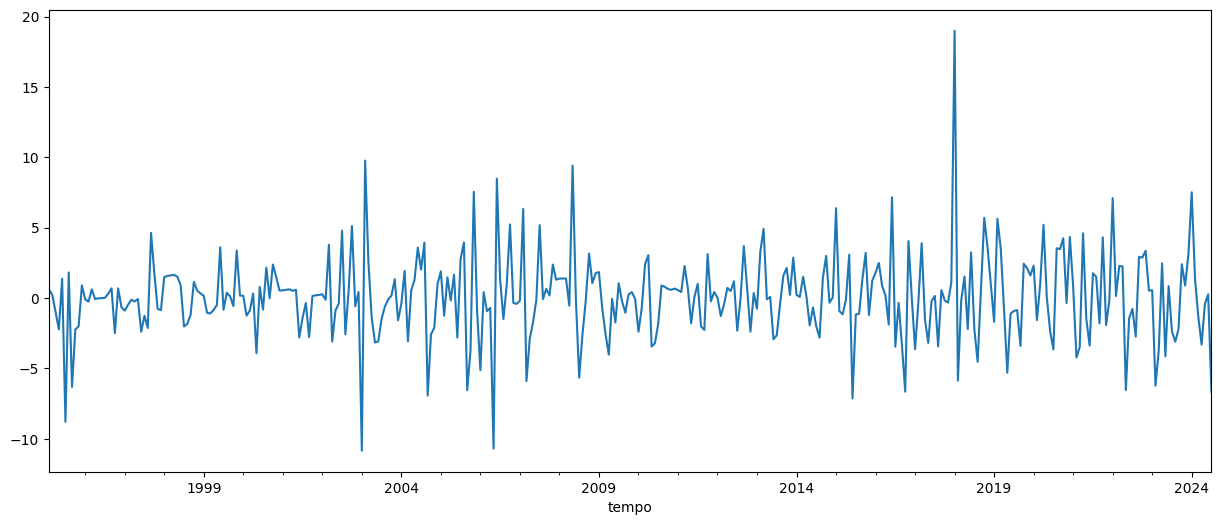

In [ ]:
# Plota a série diferenciada
cb_1diff = cb.diff()
cb_1diff.dropna(inplace=True)
cb_1diff.plot()

- Quanto menos diferenciaões na série melhor uma vez que ela perde observações com essse processo.
- O gráfico da série diferenciada aparenta estar sendo desenvolvido ao entorno de uma média constatne (no caso o zero). Realizarei outro teste ADF para checar a presença de raíz unitária novamente.

In [ ]:
adf = ADFTest(alpha=0.05) #nível de significânica de 5%
valor_p, diferenca = adf.should_diff(cb_1diff)
print(f"Valor p: {valor_p}")
print(f"Diferença: {int(diferenca)}")

Valor p: 0.01
Diferença: 0


- A série orginal com uma diferença não apresenta raíz unitária

**Para encerrar esta etapa, o teste de FISHER e periodograma são ferramentas que ajudam a identificar sazonalidade e a modelar-la. Entretando, são ferramentas que nem sempre são utilizadas e que eu considero complexas, como dispomos de ferramentas no Python de teste e ajuste automático dos parâmetros dos modelos (como descreverei mais a frente) não utilizarei tais testes e irei resolver isso mais a frente na modelagem.**

---

# **AutoARIMA -pmdarima-**

---

- Aplicando AutoARIMA
- Escolhendo o melhor modelo
- Previsões

Para escolher o melhor modelo e gerar as previsões para a série temporal, devemos aplicar a metodologia Box&Jenkins para selecionar os melhores parâmetros. Essa classe de modelos é composta por três componentes principais que são:

- **AR**: Componente autoregressivo (**parâmetro p**) - número de defasagens (lags) usados para prever o valor atual da série.

- **I**: Componente de integração (**parâmetro d**) - número de diferenciações necessárias para tornar a série estacionária.

- **MA**: Componente de médias móveis (**q**) - número de erros passados (resíduos) usados na previsão

*Exemplo: se p=2 então o modelo utiliza os dois valores anteriores da série para prever o próximo valor, i=1 a série será diferenciada uma vez (estacionariedade) e d=1 significaria que o modelo considera o erro do período anterior para melhorar a previsão.*

*Caso não haja diferenciação, o modelo passa a ser um ARMA (p, q) ao invés de um ARIMA (p, d, q) sobre a formalização:*

$$
Y_t = \phi_0 + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \epsilon_t
$$

*A fórmula acima descreve tanto o modelo ARIMA (p, d, q) quanto o ARMA (p, q), entretando o ARMA não possuí diferenciação.*

**Já para o modelo SARIMA (Modelo sazonal integrado autoregressivo de médias móveis) ou SARIMA (p, d, q) (P, D, Q). Temos a mesma lógica, porém os parâmetros adicionais (P, D, Q) modelam a sazonalidade, expandindo o modelo para lidar com padrões periódicos em séries temporais. O SARIMA pode ser formalizado como:**

$$
Y_t = \phi_0 + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \sum_{s=1}^{P} \Phi_s Y_{t-sT} + \sum_{r=1}^{Q} \Theta_r \epsilon_{t-rT} + \epsilon_t
$$


Geralmente testariamos os parâmetros até identificar o quê mellhor se ajusta baseado em certos critérios estatísticos. Entretando com a função AutoARIMA() da biblioteca pmdarima, podemos fazer com que as combinações sejam todas testadas de forma automátia até encontrar aquela que melhor satisfaz certo critério estabelecido.

---


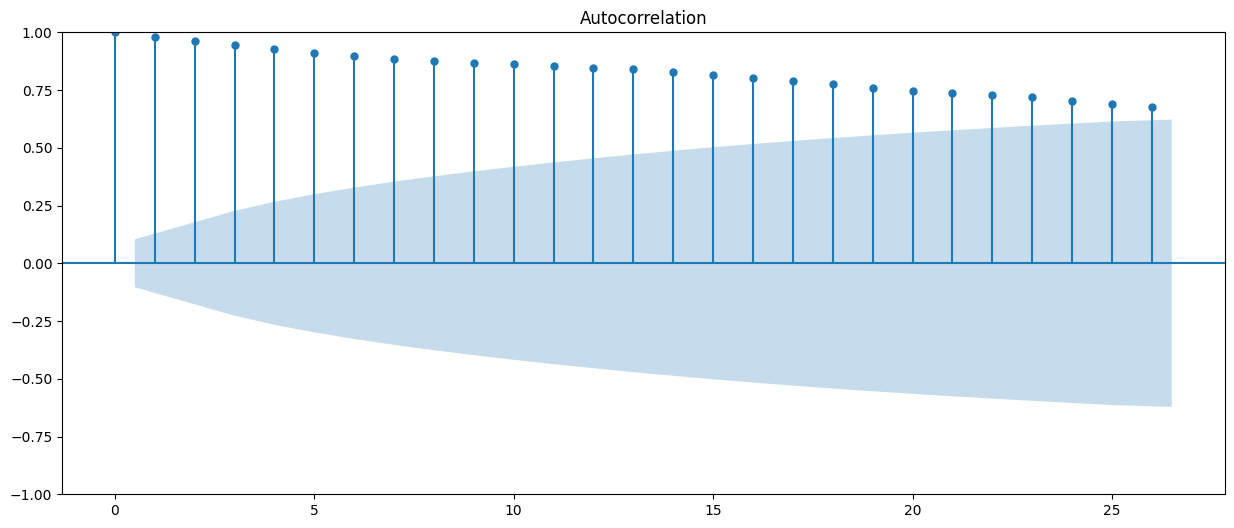

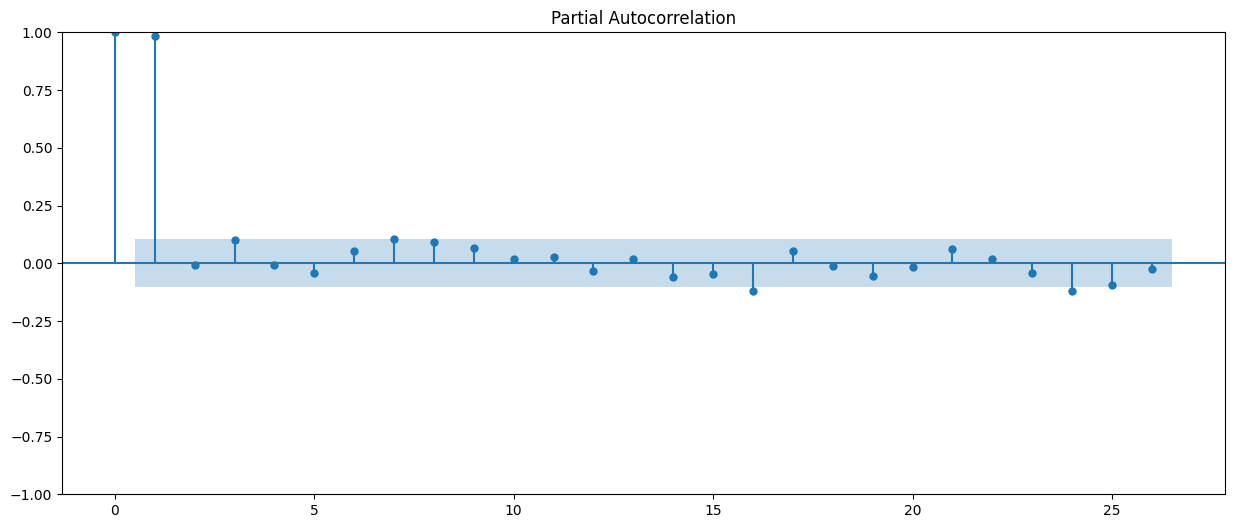

In [ ]:
# Para ajudar na seleção dos parâmetros
plot_acf(cb, alpha=0.05)
plot_pacf(cb, alpha=0.05)

- O correlograma ACF não apresenta nenhuma queda abrupta após um certo número de defasagens (lags), isso sugere que a ordem do MA (q) pode ser mais flexível ajustarei o valor no autoarima para tentar fornecer maior número de testes.


- O correlograma PACF apresenta uma queda abrupta após a segunda defasagen, como a ordem do AR (p) pode ser igual ao número de defasagens onde a autocorrelação parcial desaparece, isso sugere p=2. ajustarei o máximo do parâmetro p no autoarima para 3 para ver os resultados.

- Importante ressaltar que os modelos preferíveis são aqueles com menor número de parâmetros.

**Abaixo o autoarima será executado**

In [ ]:
escolha_modelo = auto_arima(
    cb, # dados da cesta básica original

    # Componentes padrão (p, d, q)

    start_p=0, #valor inicial do parâmetro p para teste
    start_q=0, #valor inicial do parâmetro q para teste
    d=1, #diferenciações da série - APENAS UMA PELOS TESTES!
    max_p=5, #valor maximo para os testes de p
    max_q=5, #valor maximo para os testes de q
    max_d=1, #valor maximo para os testes de d - Não quero mais de uma diferenciação!

    # Componentes sazonais (P, D, Q)
    m=12, #período para diferenciação sazonal (12 para series em meses)
    seasonal=True, #define se deve testar para SARIMA

    start_P=0,
    start_Q=0,
    D=None, #sem certeza de sazonalidade, ele testará com este parâmetro definido como None!
    max_P=2,
    max_Q=2,
    max_D=1, #realizar no máximo uma diferenciação sazonal

    seasonal_test='ocsb', #teste de sazonalidade

    # Outras configurações
    trace=True, #exibe os resultados de ajustes/tentativas
    error_action='ignore', #Se não for possível ajustar um ARIMA por qualquer motivo, isso controla o comportamento de tratamento de erros
    suppress_warnings=True, #silência avisos do autoarima

    stepwise=True #se deve usar o algoritmo passo a passo descrito em Hyndman e Khandakar (2008) para identificar os parâmetros ideais do modelo.

)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1780.262, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1782.637, Time=0.90 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1782.186, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1778.467, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1782.040, Time=0.34 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1782.053, Time=0.43 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1784.000, Time=1.38 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1780.789, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1780.302, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1773.504, Time=0.23 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1775.467, Time=0.60 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1775.470, Time=0.59 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1777.437, Time=1.27 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1775.031, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0

In [ ]:
escolha_modelo #exibe o modelo, mesmo que está acima

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
# Obtendo o critério de Akaike e Bayes
print('AIC:', escolha_modelo.aic()) #akaike information criterion
print('BIC', escolha_modelo.bic()) #bayes information criterion

AIC: 1772.5830016948012
BIC 1784.1908924342024


- Os modelo acima foi o que apresentou o melhor critério de seleção, ou seja, o mais baixo.

- Usarei ele ARIMA(1,1,1) para fazer as previsões e realizar outros testes claro

---

# **Estimação dos modelos, testes e análises**

In [ ]:
# Separando os dados em treino e teste
treino, teste = train_test_split(cb, test_size=0.2, shuffle=False) #shuffle faz que a divisão preserva a ordem temporal dos dados.

- Valores separados em 80% para treino e 20% para teste

In [ ]:
len(treino), len(teste)

(284, 71)

- 284 meses para treino
- 71 meses para teste

---
- Inicialmente testei o modelo descrito pelo pmdarima.autoarima, ele realmente apresentou bons resultados e ficou bem ajustado, entretando ... As previsões desse modelo foram constantes! Existem mutias causas para tal acontecimento, o importante é entender que isso demonstra uma inconsistencia.

- Assim teste modelos com modelagem sazonal, que pareceram se sair melhor na modelagem.

- Dos modelos SARIMA, o que será usado é aquele considerado melhor pelos seguintes critérios:
  - Menor AIC
  - Menor número de parâmetros significativos
---

In [ ]:
#ARIMA(1,1,1)
arima = ARIMA(cb, order=(1, 1, 1)).fit()

#SARIMA(1,1,1)
sarima1 = ARIMA(cb, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

#SARIMA(1,1,1)(0,1,1)
sarima2 = ARIMA(cb, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()

In [ ]:
# Sumários dos modelos
print("ARIMA(1,1,1):")
print(arima.summary())

print("\nSARIMA(1,1,1)(1,1,1,12):")
print(sarima1.summary())

print("\nSARIMA(1,1,1)(0,1,1,12):")
print(sarima2.summary())

# Comparação com base no AIC
aic_values = {
    "ARIMA(1,1,1)": arima.aic,
    "SARIMA(1,1,1)(1,1,1,12)": sarima1.aic,
    "SARIMA(1,1,1)(0,1,1,12)": sarima2.aic
}
print("\nComparação AIC:")
print(aic_values)


ARIMA(1,1,1):
                               SARIMAX Results                                
Dep. Variable:     valor_deflacionado   No. Observations:                  355
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -883.292
Date:                Fri, 20 Dec 2024   AIC                           1772.583
Time:                        18:19:06   BIC                           1784.191
Sample:                    01-01-1995   HQIC                          1777.201
                         - 07-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7303      0.115      6.359      0.000       0.505       0.955
ma.L1         -0.8466      0.092     -9.184      0.000      -1.027      -0.666
sigma2         8.6037      0.347     2

---

**AR**: O valor atual da série depende de um valor anterior (1 lag)

ar.L1 -> Estatísticamente significativo, contribue para o modelo! | O valor atual da série tende a seguir a mesma direção do valor anterior quando o coeficiente é positivo.

**I**: Os dados foram diferenciados uma vez para que fosse estacionários. | Houve uma diferenciação sazonal nos dois modelos SARIMA também.

**MA**: O valor do erro de previsão atual depende de um erro de previsão anterior

ma.L1 -> Estatísticamente significativo, contribue para o modelo | Captura a correlação entre os erros de previsão (no caso negativa).

AIC: O menor dentre os parâmetros testados pelo autoarima

---

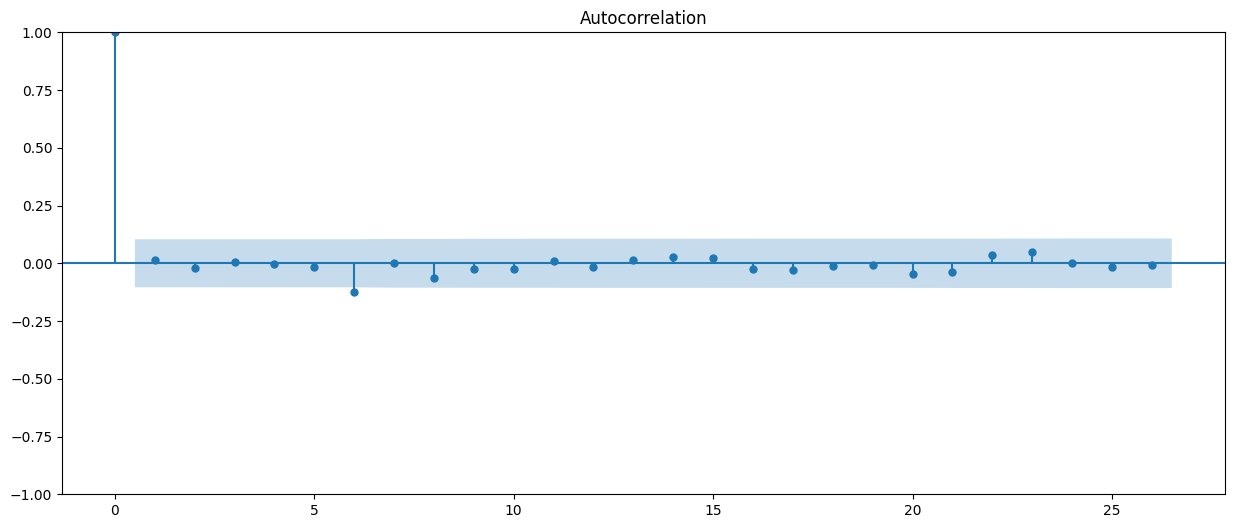

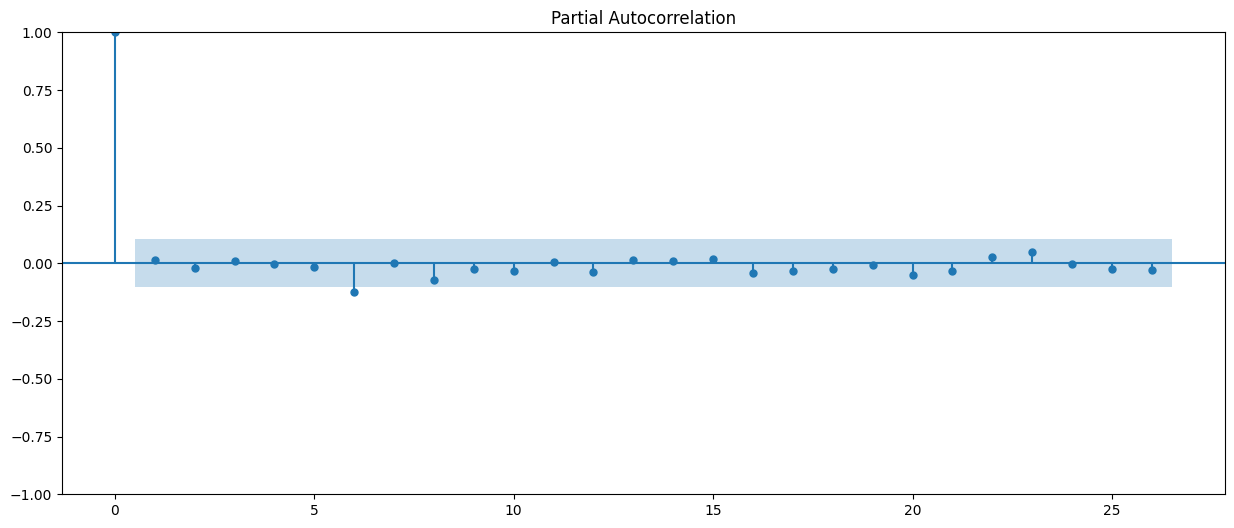

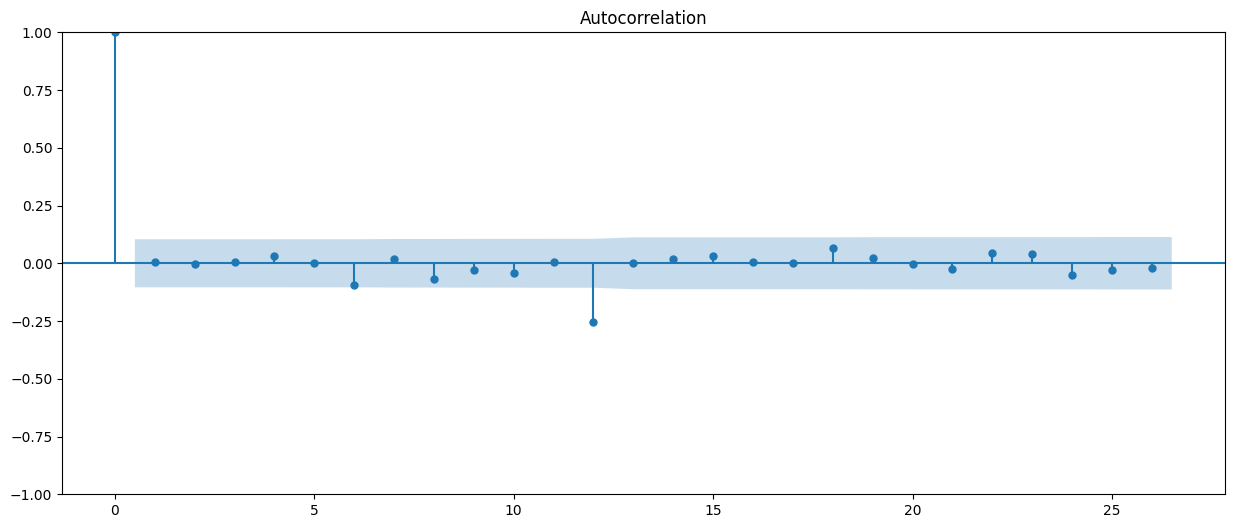

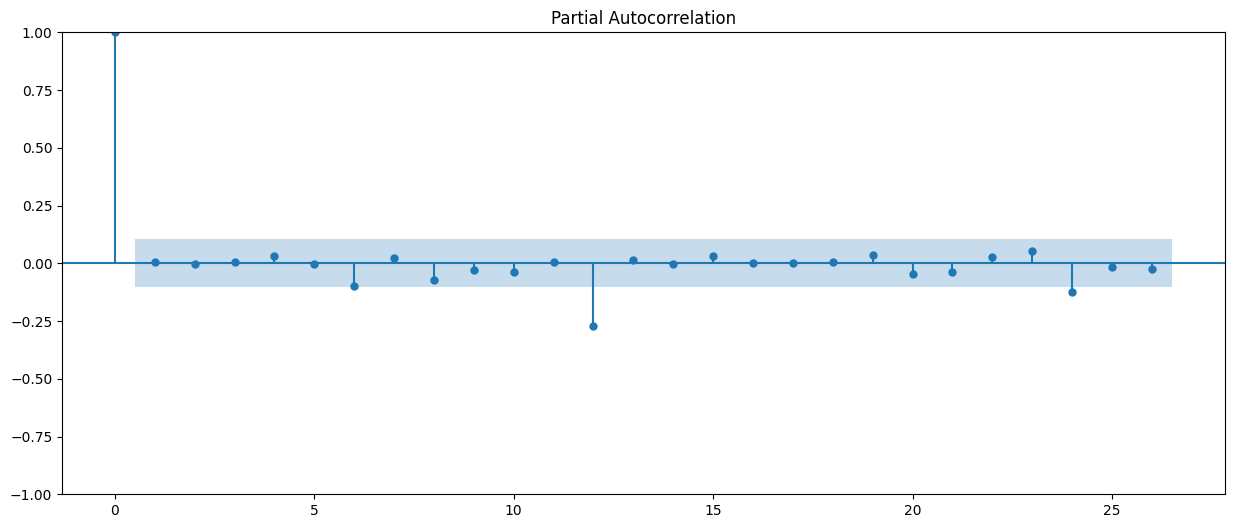

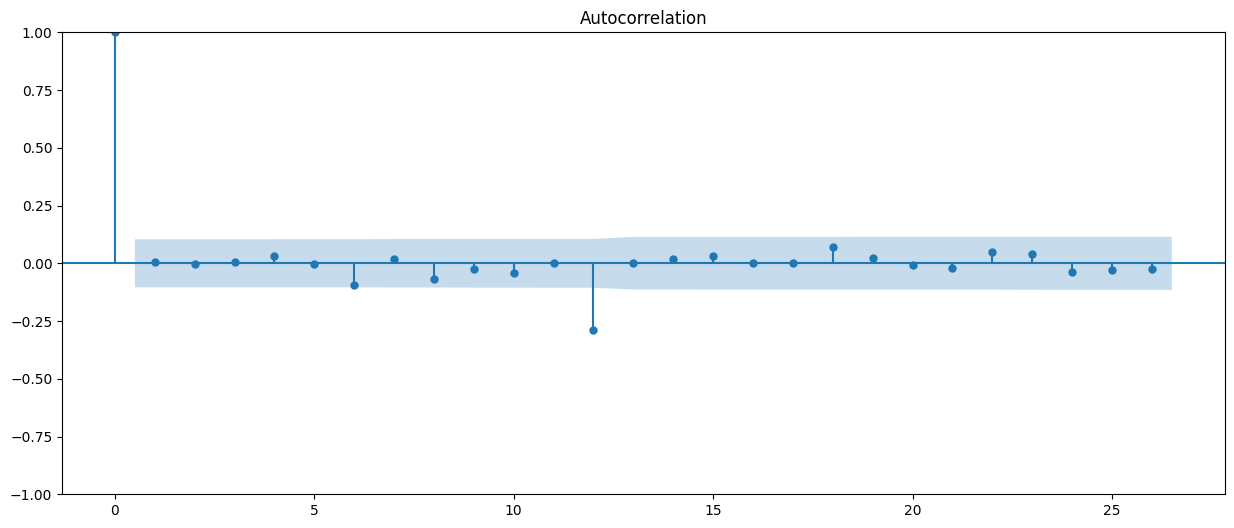

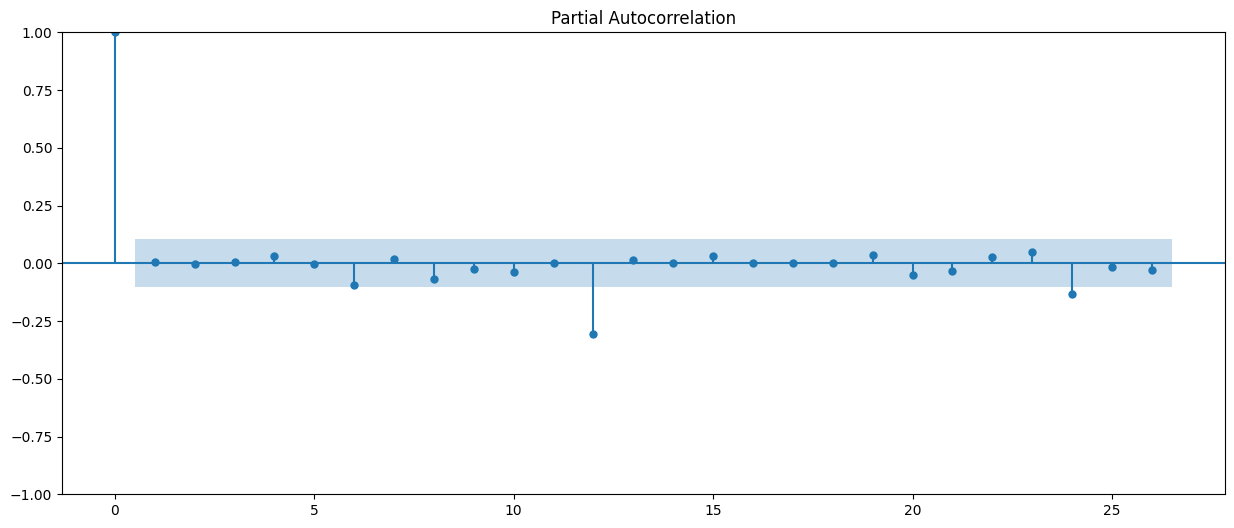

In [ ]:
# Plota as funções de autocorrelação e autocorrelação parcial dos modelos testados
plot_acf(arima.resid, alpha=0.05)
plot_pacf(arima.resid, alpha=0.05)

plot_acf(sarima1.resid, alpha=0.05)
plot_pacf(sarima1.resid, alpha=0.05)

plot_acf(sarima2.resid, alpha=0.05)
plot_pacf(sarima2.resid, alpha=0.05)

---
**FAC:**
- Os modelo estão capturando a estrutura de dependência dos dados de maneira adequada. A dependência é apenas de curto prazo devido ao decaimento rápido da autocorrelação, porém coerente com a especificação dos modelos.

- Os lags se encontram (com exceção do primeiro) dentro do intervalo de confiança. Não há necessidade de incluir mais termos MA.

- O 13º lag em algumas FACs estão um pouco fora do intervalo indicando sazonalidade anual. Entretando já estamos utilizando modelagem para a sazonalidade nos SARIMAS correspondentes a tais FACs, uma vez que os modelos apresentem ruído branco e um baixo AIC não há problemas nisso.

**FACP:**
- O pico significativo na primeira defasagem e o rápido decaimento subsequente são consistentes com a presença de um termo AR(1) no modelo.

- A ausência de outros picos significativos na FACP indica que não é necessário aumentar a ordem do processo AR no modelo.

- O 13º pico tem uma interpretação similar na FACP há que tem na FAC.

**A FACP, em conjunto com a FAC, sugerem que os modelo estimados estão capturando de forma adequada a estrutura de dependência dos dados. Pelos critérios de seleção, o mais adequado é o modelo SARIMA(1,1,1)(1,1,1)**

---

**A seguir são realizados alguns testes nos modelos relativos há: Variância do modelo, autocorrelação e distribuição dos resíduos.**

*O teste será feito no modelo selecionado porém, o mesmo código também pode ser aplicado aos outros modelos*

In [ ]:
# Gera os valores dos resíduos para os próximos testes
residuos = sarima1.resid

In [ ]:
# Teste ARCH
arch = het_arch(residuos)
print(f'Estatística LM: {arch[0]}')
print(f'p-valor: {arch[1]}')

Estatística LM: 5.857361791488824
p-valor: 0.8271012789193721


- Pelo teste ARCH não é possível afirmar que temos heterocedaticidade condicional, os resíduos do modelo podem ser considerados homocedásticos (variância constante)

- O teste ARCH confirma que a variância do modelo é homogênea, constante e tende a zero. Podemos considerar a parte aleatória como sendo um **ruído branco**.

*Ruído branco em séries temporais é uma sequência de valores aleatórios, sem autocorrelação significativa, com média constante e variância finita ao longo do tempo.*

In [ ]:
# Teste Ljung-Box
ljung_box = acorr_ljungbox(residuos, lags=10, return_df=True)
print(ljung_box)

     lb_stat  lb_pvalue
1   0.020182   0.887031
2   0.021645   0.989236
3   0.027414   0.998803
4   0.390378   0.983257
5   0.390473   0.995588
6   3.708289   0.716083
7   3.861751   0.795556
8   5.517223   0.701131
9   5.871463   0.752711
10  6.576899   0.764693


**O teste Ljung-Box verifica se os resíduos do modelo são resíduo branco, ou seja, se eles não possuem autocorrelação significativa**

- A coluna 'lb_pvalue' indica os p valores dos testes
- O teste foi realizado até o 10º lag (lags=10)
- Não há autocorrelação entre os resíduos por esse teste (p-valor > 0.05)

In [ ]:
stat, p_valor = shapiro(residuos)
print(f'Estatística do teste de Shapiro-Wilk: {stat}')
print(f'p-valor: {p_valor}')

Estatística do teste de Shapiro-Wilk: 0.5987026145567231
p-valor: 7.157892445005038e-28


- Rejeitada a Hipótese nula. Os resíduos não seguem uma distribuição normal.

In [ ]:
stat, p_valor = jarque_bera(residuos)
print(f'Estatística do teste de Jarque-Bera: {stat}')
print(f'p-valor: {p_valor}')

Estatística do teste de Jarque-Bera: 100604.21429463076
p-valor: 0.0


- Rejeitada a Hipótese nula. Os resíduos não seguem uma distribuição normal.

<Axes: >

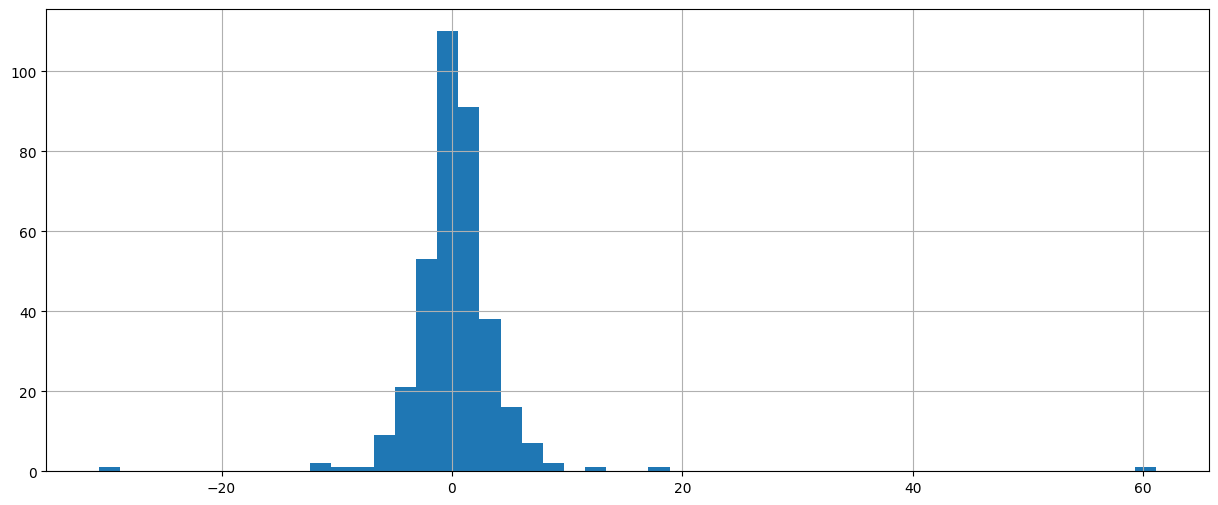

In [ ]:
residuos.hist(bins=50) #normalidade dos resíduos

<Axes: ylabel='Count'>

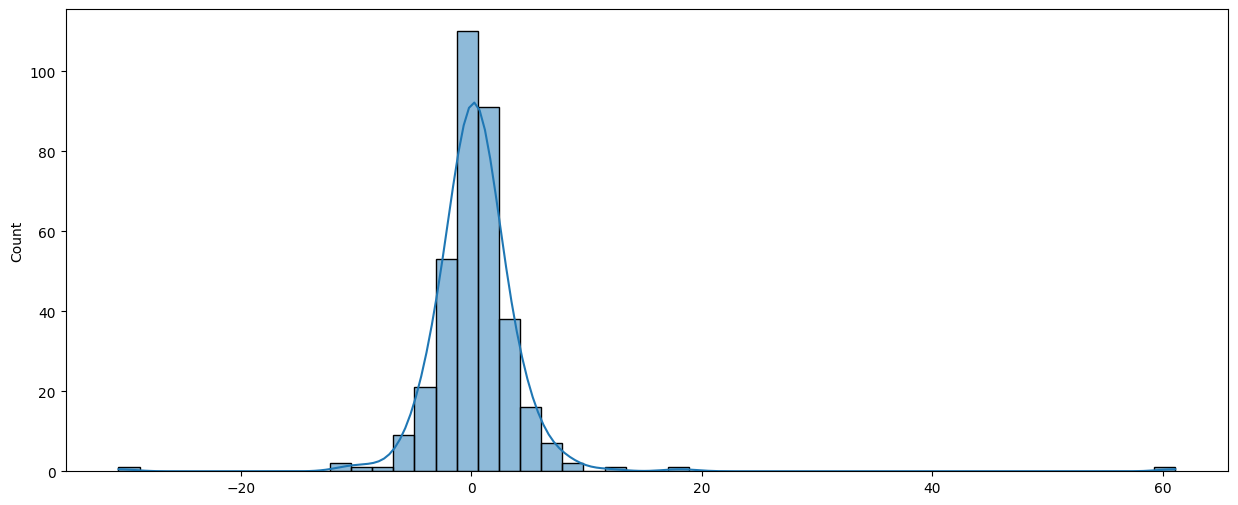

In [ ]:
sns.histplot(residuos, bins=50, kde=True) #normalidade dos residuos

**A distribuição dos resíduos não é exatamente normal, porém dificilmente é em dados "do mundo real" coloquei aqui o histograma dos resíduos apenas por formalidade. Embora visualmente aparente ser normalmente distribuído, pelos testes realizados podemos observar que não é.**

---

# **Previsões e gráficos**

In [ ]:
# Realiza previsões com o melhor modelo -SARIMA(1,1,1)(1,1,1)-

previsao_6 = sarima2.get_forecast(steps=6).predicted_mean #6 periodos de previsao
previsao_12 = sarima2.get_forecast(steps=12).predicted_mean #12 periodos de previsao
previsao_24 = sarima2.get_forecast(steps=24).predicted_mean #24 periodos de previsao
previsao_36 = sarima2.get_forecast(steps=36).predicted_mean #36 periodos de previsao

lista_previsoes = [previsao_6, previsao_12, previsao_24, previsao_36] #lista com todas as previsoes

print("Previsões:")
for prev in lista_previsoes:
  print(prev)


Previsões:
2024-08-01    86.265368
2024-09-01    86.551640
2024-10-01    88.772357
2024-11-01    89.799640
2024-12-01    91.035984
2025-01-01    93.541928
Freq: MS, Name: predicted_mean, dtype: float64
2024-08-01    86.265368
2024-09-01    86.551640
2024-10-01    88.772357
2024-11-01    89.799640
2024-12-01    91.035984
2025-01-01    93.541928
2025-02-01    93.202090
2025-03-01    93.391212
2025-04-01    94.019745
2025-05-01    92.198696
2025-06-01    91.847111
2025-07-01    90.211016
Freq: MS, Name: predicted_mean, dtype: float64
2024-08-01    86.265368
2024-09-01    86.551640
2024-10-01    88.772357
2024-11-01    89.799640
2024-12-01    91.035984
2025-01-01    93.541928
2025-02-01    93.202090
2025-03-01    93.391212
2025-04-01    94.019745
2025-05-01    92.198696
2025-06-01    91.847111
2025-07-01    90.211016
2025-08-01    89.389220
2025-09-01    89.242981
2025-10-01    91.193588
2025-11-01    92.052182
2025-12-01    93.183178
2026-01-01    95.623330
2026-02-01    95.242403
2026-03

- Agora com os valores das previsões temos que avaliar qual das previsões é melhor.
- **Com relação aos dados dos quatro meses posteriores a Julho temos os valores já divulgados pelo NEPE (Agosto, Setembro, Outubro e Novembro) Assim, ao final iremos comparar os valores para avaliar a acertividade do modelo.**

**MAPE**

O Erro Percentual Absoluto Médio (MAPE) é uma métrica amplamente utilizada para
avaliar a precisão de modelos de previsão, incluindo os modelos SARIMA. Ele mede a precisão
das previsões ao calcular a média dos erros percentuais absolutos entre os valores previstos e
os valores reais, se encontra mais bem descrito na equação abaixo:

  $
  \text{MAPE} = \frac{1}{n} \sum_{t=1}^{n} \left| \frac{Y_t - \hat{Y}_t}{Y_t}     
  \right| \times 100
  $

Onde:
- $Y_t $: valor real no tempo $ t $,
- $ \hat{Y}_t $: valor previsto no tempo $ t $,
- $ n $: número total de observações.



- Irei utilizar a seguir o MAPE para avaliar qual das previsões feitas foi a melhor (que teve melhor ajuste a realidade).
- O critério é o menor MAPE, a que apresentar o menor MAPE será considerada melhor ajustada.


In [ ]:
real_6 = cb[-6:] #últimos 6 valores da série original
mape_6 = mean_absolute_percentage_error(real_6, previsao_6) #calcula mape para 6 períodos de previsão

real_12 = cb[-12:] #últimos 12 valores da série original
mape_12 = mean_absolute_percentage_error(real_12, previsao_12) #calcula mape para 12 períodos de previsão

real_24 = cb[-24:] #últimos 24 valores da série original
mape_24 = mean_absolute_percentage_error(real_24, previsao_24) #calcula mape para 24 períodos de previsão

real_36 = cb[-36:] #últimos 36 valores da série original
mape_36 = mean_absolute_percentage_error(real_36, previsao_36) #calcula mape para 36 períodos de previsão

lista_mape = [mape_6, mape_12, mape_24, mape_36] #lista com todos os MAPEs
n_ind = 6


# Exibe os Resultados
print(f'MAPE para 4 períodos: {mape_4:.2f}')
for m in lista_mape:
  if n_ind == 6:
    print(f'MAPE para {n_ind} períodos: {m:.2f}')
    n_ind += 6 #aumenta o indice da variável de controle
  else:
    print(f'MAPE para {n_ind} períodos: {m:.2f}')
    n_ind += 12 #aumenta o indice da variável de controle

MAPE para 4 períodos: 0.06
MAPE para 6 períodos: 0.07
MAPE para 12 períodos: 0.03
MAPE para 24 períodos: 0.05
MAPE para 36 períodos: 0.05


---

- Como o MAPE mede o erro percentual médio entre os valores reais $Y_t $ e os valores previstos pelo modelo $ \hat{Y}_t $ . Quanto menor for tal erro, melhor. Pois, em média, o modelo tem menor erro percentual em relação aos valores reais.

- No geral todos apresentaram valores percentuais baixos, e nenhum modelo aparenta estar capturando errado o padrão dos dados, mesmo no longo prazo.

- **Para conclusão: O modelo selecionado será a previsão para 12 períodos (12 meses ou um ano) - Menor MAPE -**

---

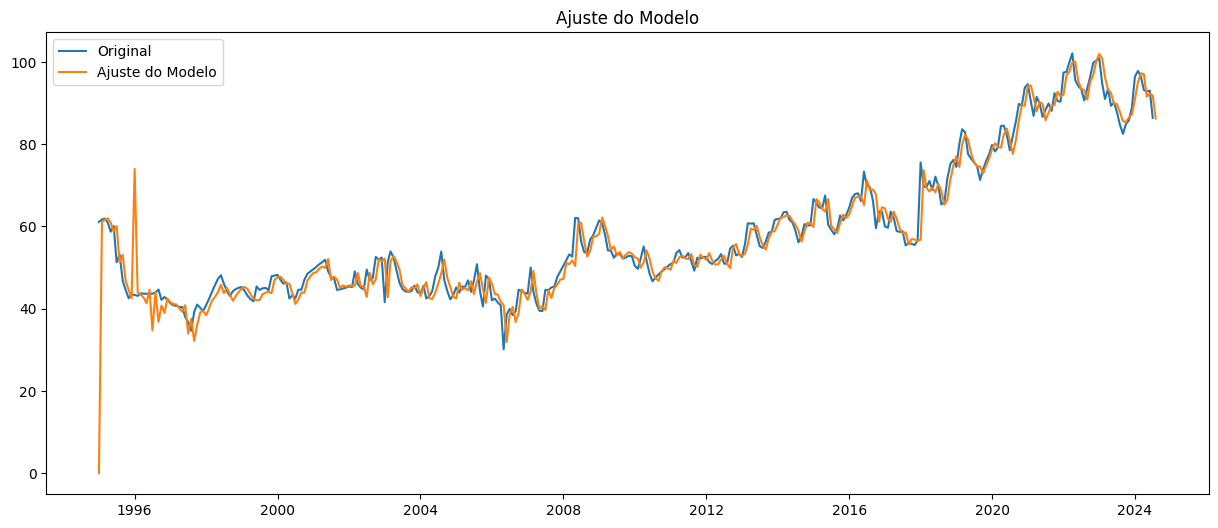

In [ ]:
# Gráfico: dados originais e previsões
plt.plot(cb, label="Original")
plt.plot(sarima2.predict(start=0, end=len(cb)), label="Ajuste do Modelo")
plt.legend()


plt.title("Ajuste do Modelo")
plt.show()

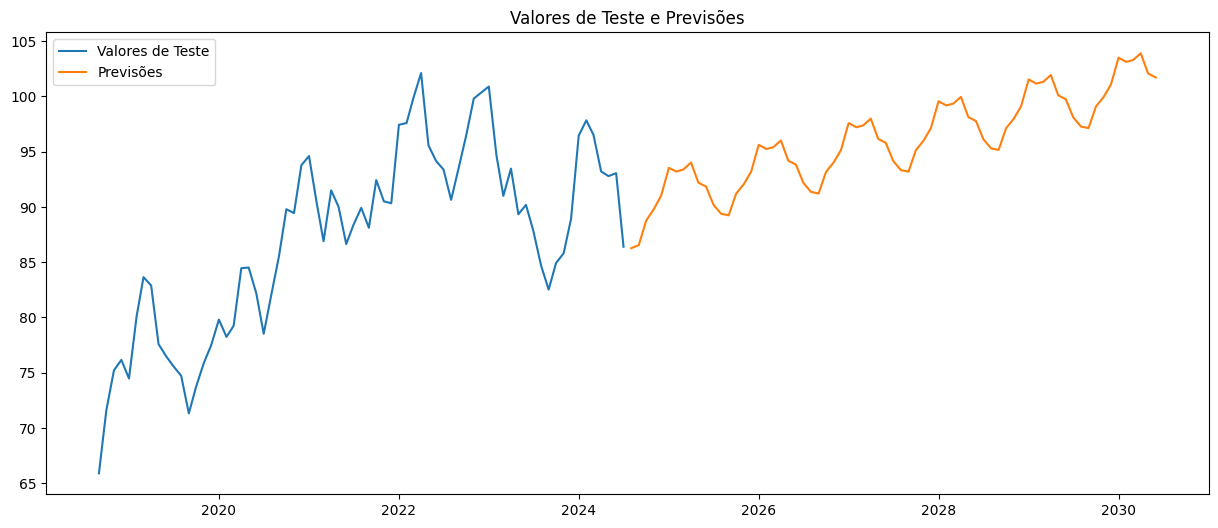

In [ ]:
# Gráfico de teste e previsões
test_start = len(cb) - int(len(cb) * 0.2)  # Últimos 20% dos dados
plt.plot(cb[test_start:], label="Valores de Teste")
plt.plot(sarima2.get_forecast(steps=len(cb) - test_start).predicted_mean, label="Previsões")
plt.legend()
plt.title("Valores de Teste e Previsões")
plt.show()

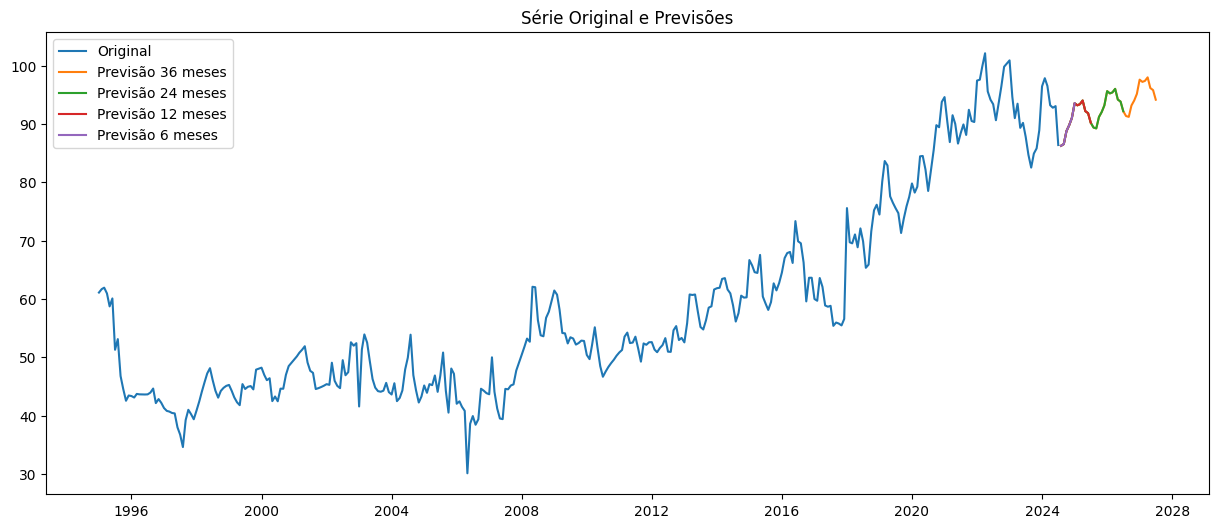

In [ ]:
# Gráfico da série completa e previsões
plt.plot(cb, label="Original")
plt.plot(sarima2.get_forecast(steps=36).predicted_mean, label="Previsão 36 meses")
plt.plot(sarima2.get_forecast(steps=24).predicted_mean, label="Previsão 24 meses")
plt.plot(sarima2.get_forecast(steps=12).predicted_mean, label="Previsão 12 meses")
plt.plot(sarima2.get_forecast(steps=6).predicted_mean, label="Previsão 6 meses")
plt.legend()
plt.title("Série Original e Previsões")
plt.show()

---

# **COMPARAÇÃO COM VALORES REAIS**

---
Para finalizar, o NEPE já tem divulgado os dados do custo da cesta básica para mais quatro meses conforme dito anteriormente.

A seguir irei:
- Importar os dados dos quatro meses seguintes já deflacionados (feito no google sheets por ser mais prático e rápido).

- Realizar uma previsão de 4 meses para avaliar o quão acertivo é o modelo.

- Avaliar a variação real da cesta básica em todo o período e seus impactos

- Por último: Colocar uma avaliação final com alguns pontos que merecem destaque!

In [ ]:
# Importa os dados para finalizar
path2 = '/content/drive/MyDrive/PROJETOS DS/MÉTODOS ESTATÍSTICOS DE PREVISÃO_Custo da cesta básica em São João del-Rei/Dados/Limpos/cestabasica_previsoes.xlsx'
cb2 = pd.read_excel(path2, sheet_name=0)

In [ ]:
cb2.head()

,tempo,custo,ipca_numero_indice_(dez94=100),var_mes,ipca_acumulado,valor_deflacionado,Varição real da cesta no período
0,1995-01-01,61.11,1033.74,0.017000,1.000000,61.110000,0.000000
1,1995-02-01,62.33,1044.28,0.010196,1.010196,61.700898,0.009669
2,1995-03-01,63.55,1060.47,0.015504,1.025858,61.948171,0.004008
3,1995-04-01,64.06,1086.24,0.024301,1.050786,60.963861,-0.015889
4,1995-05-01,63.37,1115.24,0.026698,1.078840,58.739019,-0.036494


In [ ]:
cb2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   tempo                             359 non-null    datetime64[ns]
 1   custo                             359 non-null    float64       
 2   ipca_numero_indice_(dez94=100)    359 non-null    float64       
 3   var_mes                           359 non-null    float64       
 4   ipca_acumulado                    359 non-null    float64       
 5   valor_deflacionado                359 non-null    float64       
 6   Varição real da cesta no período  359 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 19.8 KB


In [ ]:
cb2.isnull().sum().sum()

0

In [ ]:
#cb2.set_index('tempo', inplace=True)
cb2.drop(cb2.iloc[:,:4], axis=1, inplace=True)
cb2.head()

,valor_deflacionado,Varição real da cesta no período
tempo,,
1995-01-01,61.110000,0.000000
1995-02-01,61.700898,0.009669
1995-03-01,61.948171,0.004008
1995-04-01,60.963861,-0.015889
1995-05-01,58.739019,-0.036494


In [ ]:
valores_comparar = cb2[-4:].drop('Varição real da cesta no período', axis=1)
valores_comparar

,valor_deflacionado
tempo,
2024-08-01,87.107786
2024-09-01,83.750794
2024-10-01,87.259960
2024-11-01,88.580529


Proseguiremos após este breve tratamento.

---

Previsão para o modelo de 4 meses


In [ ]:
previsao_4 = sarima2.get_forecast(steps=4).predicted_mean #4 periodos de previsao

In [ ]:
real_4 = cb[-4:]
mape_4 = mean_absolute_percentage_error(real_4, previsao_4) #calcula mape para 4 períodos de previsão

print(f'MAPE para 4 períodos: {mape_4:.2f}')

MAPE para 4 períodos: 0.06


Para o período mais curto de 4 meses, o MAPE foi maior que os outros vistos anteriormente porém nada muito elevado. A comparação dos valores previstos com o real será a parte mais interessante.


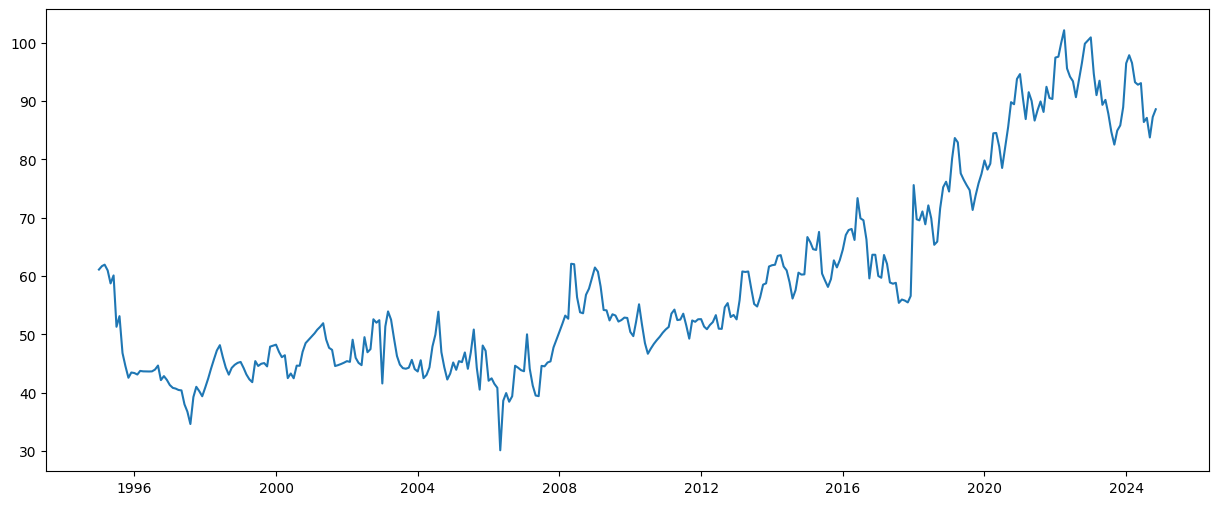

In [ ]:
# Gráfico da série completa e previsões
plt.plot(cb2['valor_deflacionado'], label="Original")
plt.show()

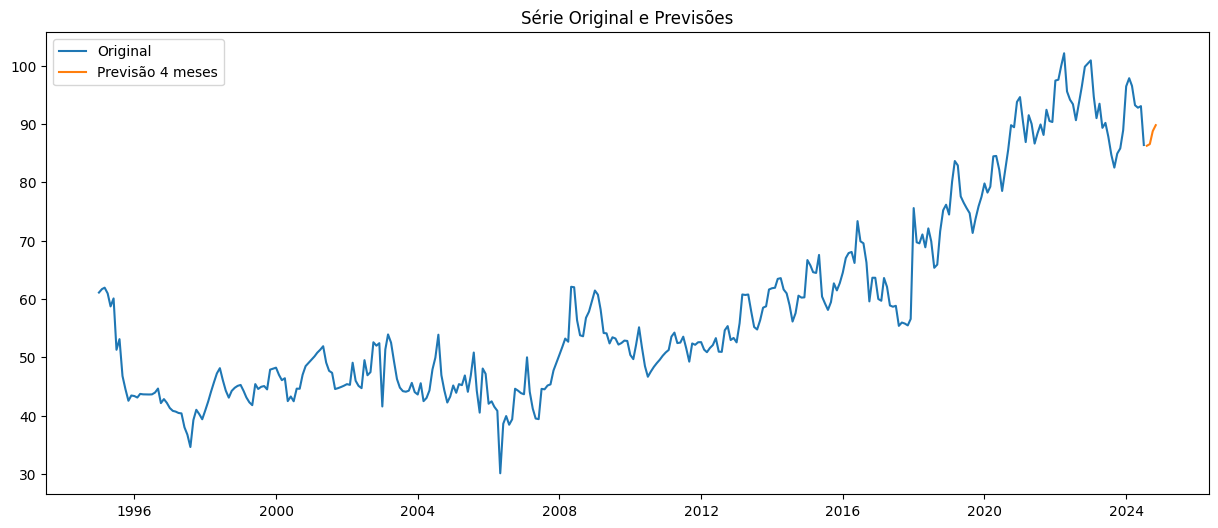

In [ ]:
# Gráfico da série completa e previsão de 4 meses
plt.plot(cb, label="Original")
plt.plot(sarima2.get_forecast(steps=4).predicted_mean, label="Previsão 4 meses")
plt.legend()
plt.title("Série Original e Previsões")
plt.show()

In [ ]:
comparar = pd.concat([valores_comparar, previsao_4], axis=1)
comparar.head()

,valor_deflacionado,predicted_mean
2024-08-01,87.107786,86.265368
2024-09-01,83.750794,86.551640
2024-10-01,87.259960,88.772357
2024-11-01,88.580529,89.799640


In [ ]:
comparar['Diferença Previsão'] = comparar['valor_deflacionado'] - comparar['predicted_mean']
comparar.head()

,valor_deflacionado,predicted_mean,Diferença Previsão
2024-08-01,87.107786,86.265368,0.842418
2024-09-01,83.750794,86.551640,-2.800846
2024-10-01,87.259960,88.772357,-1.512397
2024-11-01,88.580529,89.799640,-1.219111


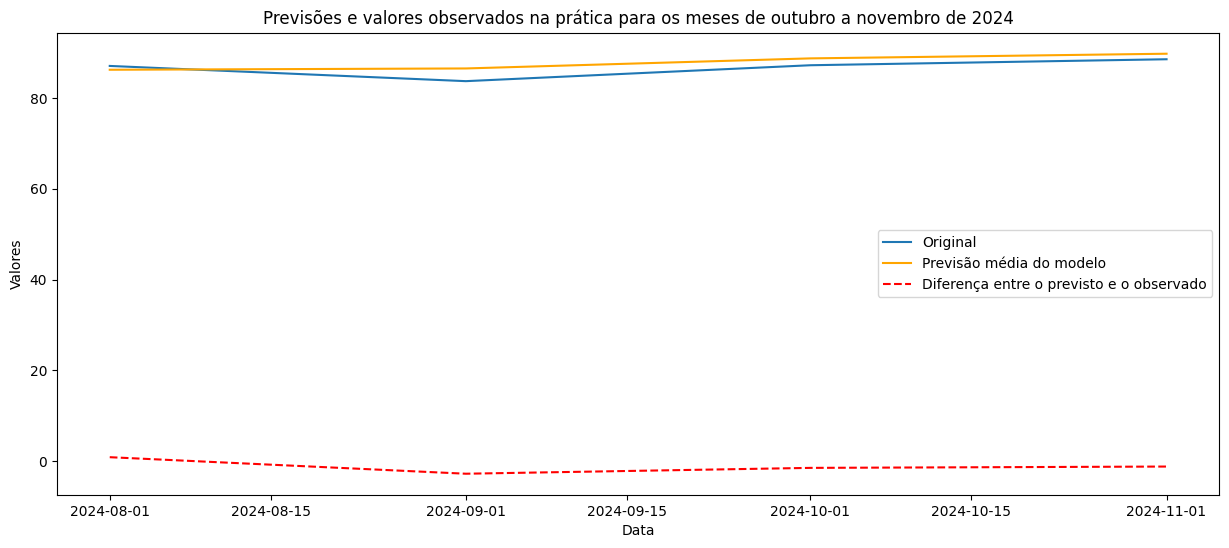

In [ ]:
# Gráfico Previsões, valores observados na prática e diferença
plt.plot(comparar['valor_deflacionado'], label="Original")
plt.plot(comparar['predicted_mean'], label="Previsão média do modelo", color='orange')
plt.plot(comparar['Diferença Previsão'], label="Diferença entre o previsto e o observado", color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Previsões e valores observados na prática para os meses de outubro a novembro de 2024')
plt.legend()
plt.show()

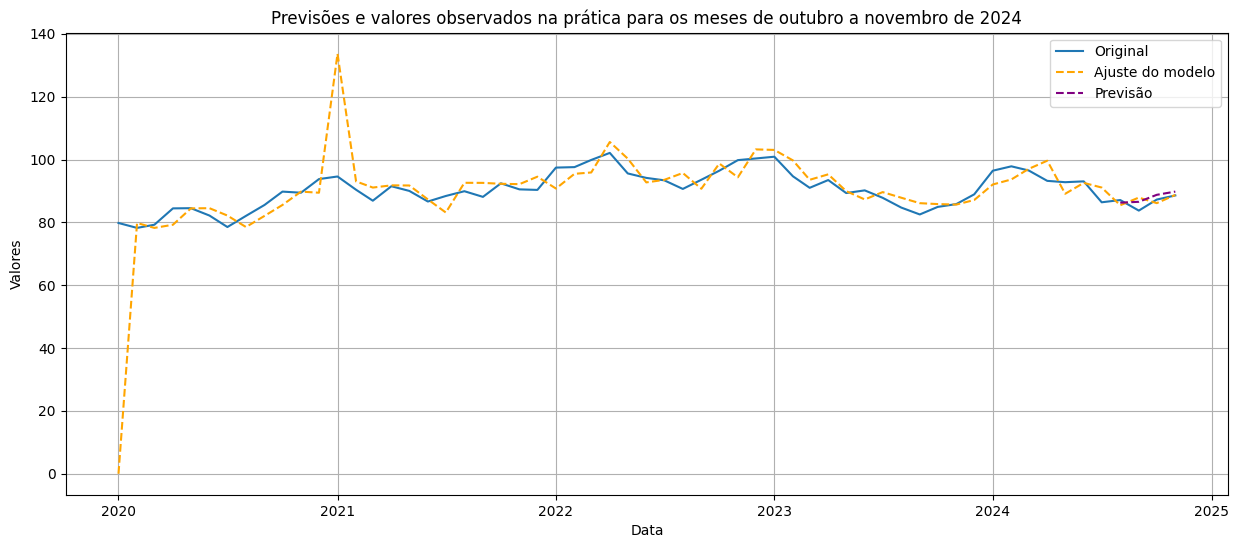

In [ ]:
# Gráfico: dados originais e previsões
cb3 = cb2.copy()
cb3.drop('Varição real da cesta no período', axis=1, inplace=True)
cb3 = cb3[cb3.index >= '2020-01-01']

sarima_filtro = ARIMA(cb3, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
sarima_forecast = sarima_filtro.get_forecast(steps=4).predicted_mean

plt.plot(cb3.index, cb3, label='Original') #série original
plt.plot(cb3.index, sarima_filtro.fittedvalues, label='Ajuste do modelo', color='orange', linestyle='--') #ajuste do modelo
plt.plot(comparar.index, comparar['predicted_mean'], label='Previsão', color='purple', linestyle='--') # previsões

plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Previsões e valores observados na prática para os meses de outubro a novembro de 2024')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
comparar

,valor_deflacionado,predicted_mean,Diferença Previsão
2024-08-01,87.107786,86.265368,0.842418
2024-09-01,83.750794,86.551640,-2.800846
2024-10-01,87.259960,88.772357,-1.512397
2024-11-01,88.580529,89.799640,-1.219111


---